## BRCG analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
# ignore warning related to deprecated modules inside packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# train with fixed seed to eliminate different results
np.random.seed(777)
from IPython.display import Image

### Rulesets

Below as an example, there is a simple ruleset which aims to approximate a model which can classify the samples correctly, according to their statuses:

In [7]:
dnf = [
    'ssc_p > 58.00 AND workex  ', 
    'hsc_p > 52.00 AND degree_p > 65.00', 
    'ssc_p > 64.00 AND hsc_p > 65.00', 
    'ssc_p > 52.00 AND hsc_p > 52.00 AND degree_t != Sci&Tech AND mba_p <= 58.78'
]

Therefore some applications of rulesets are required to remain manageable, that is why sometimes it is necessary to formulate constraints on their complexity.
This parameter takes 2 factors into account: the number of clauses, and the number of terms. Each factor is amplified by the $\delta_0$, $\delta_1$ hyperparameters.

$c = \sum_{k\in K} \delta_0 + \sum_{i\in k} ^{k}\delta_1$ 

In [11]:
import aix360.algorithms.rbm
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BooleanRuleCG

###  Analysis of the Framework
#### Overview of the API

Below a quick glance of the algorithm's interface, and a brief overview of its process will be presented. Details of its inner structure both on algorithmic and implementation level will be explained in a later chapter.

The Boolean Decision Rules Generator Framework (BRCG) expects its input in a form of binarized labels, therefore both the input and the target variables need to be preprocessed.

**Binarizing**

**Predictor labels**

Dropping index, and salary labels as they are redundant for the current problem.

In [16]:
categorical_features = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
fb = FeatureBinarizer(colCateg=categorical_features, negations=True, returnOrd=True)

X = data.drop(columns=["sl_no", "salary", "status"])
X_bin, X_std = fb.fit_transform(X)

**Target variable**

In [16]:
Y = data["status"].map(lambda x: 1 if x == "Placed" else 0).astype(int)

**Generating rules**

Training the rule generator model, with small assigned $\delta_0$, $\delta_1$ parameters.

In [17]:
def explain_with_BRCG(X, y, CNF=False, lambda0=1e-1, lambda1=1e-2, verbose=True):
    # Instantiate BRCG with small complexity penalty
    br_model = BooleanRuleCG(lambda0, lambda1, CNF=False)
    # Train, print, and evaluate model
    br_model.fit(X, y)
    if verbose:
        print('Training accuracy:', metrics.accuracy_score(y, br_model.predict(X)))
    if br_model.CNF:
        print('Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:')
    else:
        print('Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:')
    print(br_model.explain()['rules'])
    return br_model

**Running the algorithm**

In [18]:
rules = explain_with_BRCG(X_bin, Y)

Learning DNF rule with complexity parameters lambda0=0.1, lambda1=0.01
Initial LP solved
Iteration: 1, Objective: 0.2960
Training accuracy: 0.8418604651162791
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:
['ssc_p > 58.00 AND hsc_p > 52.00']


#### Performance analysis

In order to propose an improvement for the current algorithm, its main behavior should be thoroughly examined. Generally, the AIX BRCG package is an AI explainability tool, therefore its main objective is to provide relatively high accuracy in a low complexity model. It can also be claimed that the algorithm performs poorly with higher complexity parameters. Below, the earlier proposed evaluation metrics are showcased on this algorithm with the given dataset.

**Examination of accuracy as a function of complexity:**

*Counting the number of conjunctions and terms in the ruleset*

In [19]:
def rule_set_transform(rules):
    conjunction = 0
    literal = 0
    for rule in rules:
        conjunction += 1
        literal_list = rule.split("AND")
        for l in literal_list:
            literal += 1
            
    return conjunction, literal

*Calculating the complexity value, accoding to the earlier proposed formula*

In [20]:
def calc_dnf_complexity(rules, lambda0=1, lambda1=1):
    if len(rules) == 0:
        return 0

    if type(rules[0][0]) is str:
        conj, lit = rule_set_transform(rules)
        
    complexity = conj * lambda0 + lit * lambda1
    return complexity

*Extracting the confusion features from the model*

In [21]:
def calc_conf_props(y_, y_pred_):
    
    conf_matrix = confusion_matrix(y_, y_pred_).flatten()  
    tpr = conf_matrix[3]
    fpr = conf_matrix[1]
    tnr = conf_matrix[0]
    fnr = conf_matrix[2]
    
    return tpr, fpr, tnr, fnr

*Generating 20 models with gradually increasing lambda parameters, and evaluating each resulted model*

In [ ]:
from sklearn.metrics import confusion_matrix

np.random.seed(777)
brcg_metrics = {'accuracy': [], 'complexity': [], 'dnf': [], 'tp': [], 'fp': [], 'tn': [], 'fn': [], 'lambda': []}
number_of_models_to_train = 20
lambda_values = np.linspace(0.000001, 0.01, number_of_models_to_train)

for i, l in enumerate(np.flip(lambda_values)):
    print("iter:", i)
    
    brcg = explain_with_BRCG(X_bin, Y, lambda0=l, lambda1=l, verbose=False)
    y_pred = brcg.predict(X_bin)
    rules = brcg.explain()['rules']
    complexity = calc_dnf_complexity(rules)
    accuracy = metrics.accuracy_score(Y, y_pred)
    true_pos, false_pos, true_neg, false_neg = calc_conf_props(Y, y_pred)
    
    brcg_metrics['accuracy'].append(accuracy)
    brcg_metrics['complexity'].append(complexity)
    brcg_metrics['dnf'].append(rules)
    brcg_metrics['tp'].append(true_pos)
    brcg_metrics['fp'].append(false_pos)
    brcg_metrics['tn'].append(true_neg)
    brcg_metrics['fn'].append(false_neg)
    brcg_metrics['lambda'].append(f"l0, l1 = {l}")

Visualizing the Accuracy - Complexity diagram:

In [23]:
import os

if not os.path.exists("plts"):
    os.mkdir("plts")

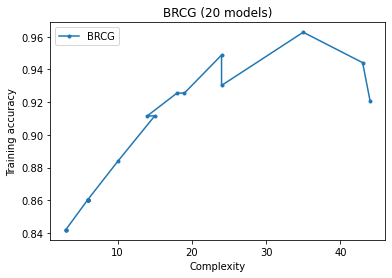

In [26]:
import plotly.graph_objects as go

plt.plot(np.array(brcg_metrics['complexity']),np.array(brcg_metrics['accuracy']), marker='.', label='BRCG') 
plt.xlabel('Complexity')
plt.ylabel('Training accuracy')
plt.title('BRCG (20 models)')
plt.legend()
plt.savefig('plts/comp-acc.png')

Due to the high imbalance in the dataset, the algorithm starts with a pretty high accuracy even with the lowest complexity, and it peaks at 96% accuracy, which later declines as the complexity increases.

**Plotting the ROC curve**

In [29]:
n_samples = Y.count()
pos_samples = Y.sum()
neg_samples = n_samples - pos_samples

tpr = [(TP / pos_samples) for TP in brcg_metrics['tp']]
fpr = [(FP / neg_samples) for FP in brcg_metrics['fp']]
precision = [(brcg_metrics['tp'][i] / (brcg_metrics['tp'][i] + brcg_metrics['fp'][i])) for i in range(len(brcg_metrics['tp']))]

In [33]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Scatter(x=fpr, y=tpr))
fig.update_traces(hovertext=l, selector=dict(type='scatter'), mode='markers')
fig.update_layout(title="ROC Curve",
                  xaxis_title="False Positive Rate", 
                  yaxis_title="True Positive Rate",
                  width=500,
                  height=500)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.write_image("plts/roc.png")

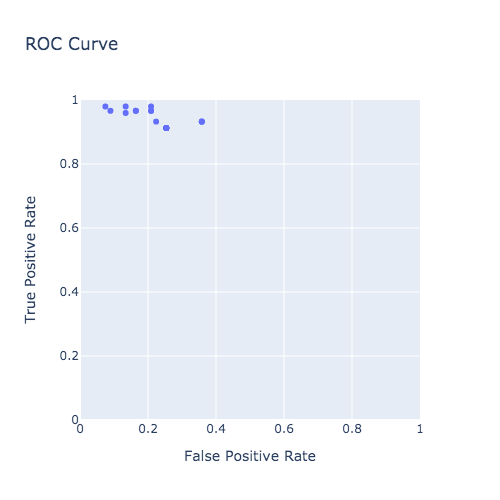

In [34]:
Image(filename='plts/roc.png') 

**Plotting the Precision - Recall curve** 

In [35]:
fig = go.Figure(data=go.Scatter(x=tpr, y=precision))
fig.update_traces(hovertext=l, selector=dict(type='scatter'), mode='markers')
fig.update_layout(title="Precision - Recall Curve",
                  xaxis_title="Recall", 
                  yaxis_title="Precision",
                  width=500,
                  height=500)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.write_image("plts/prec-rec.png")


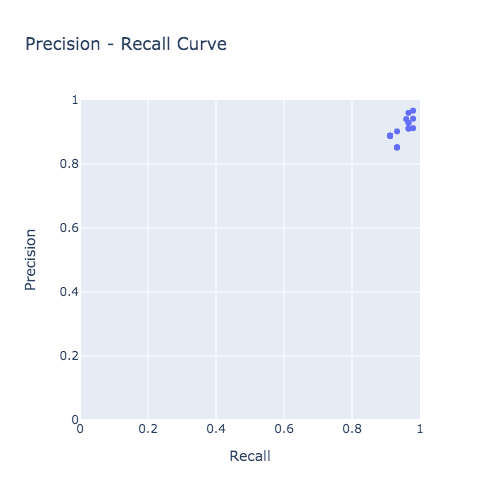

In [36]:
Image(filename='plts/prec-rec.png') 

#### Semantical analysis

As it was previously mentioned, one of the major strengths of rule-based models, is that they can enclose complex mathematical connections into logic functions. This provides an opportunity to analyze the resulting models with tools that support formal logical reasoning.


**Binary Decision Diagrams** (BDD)

While there could be many different decision trees built up from a given ruleset, BDDs remain unique as long as the order of the variables in the rules are fixed. Since BDDs are the canonical representation of boolean functions.
BDDs are represented as a rooted, directed, acyclic graph, which consists of several nodes (here: terms) and two terminal nodes, which indicates the result of the binary classification label (originally: the truth value of the boolean function).

In practical and popular usage an optimized version of BDDS are used, called: Reduced Ordered Binary Decision Diagram (ROBDD), which cuts the initial graph and leaves out redundancies.

**Transformation of the terms into logic variables**

Currently terms are a data set dependent representation of the engineering model. To visualize the in the above mentioned representations additional knowledge (like threshold value, operator type) is not required to be present at the first glance. The most important factor is the encapsulation of its truth value (whether the term are satisfied or not), while maintaining the orderability property of the set of terms.

Assuming that given a feature x, which set of interpretation ranges between 0 and 10. Many constraints could be defined for x over this set, take `x <= 3`, `x > 2` and `x <= 1` as an example. Since the set of interpretations can be sorted, an order over these terms can be also defined. A term $a > b$ if $d(b) \subseteq d(a)$ $d(x)$ is a funtion which returns $e$ collection of samples which satisfies the term $x$, and $e \in D$ which is the initial dataset.

A problem arises when to terms which uses different comparing operators are need to be compared since for instance 

$d(x <= 1) \cap d(x > 2) = \emptyset$ 

and 

$ d(x <= 3) \cap d(x > 2) \ne \emptyset$    but    $(d(x <= 3) \setminus d(x > 2) \ne \emptyset) \cap (d(x > 2) \setminus d(x <= 3) \ne \emptyset)$

Therefore these terms cannot be compared by this definition. Let us describe the motivation behind the definition of this ordering. The implication ($\implies$) operator needs to be introduced in order to optimize the boolean functions. Because if a set of samples satisfies the term  `x <= 1` it should also satisfy `x <= 3`.
There are 3 cases:
- term $a > b : a \implies b$
- term $d(a) \cap d(b) = \emptyset : a \iff \neg b$
- term $d(a) \cap d(b) \ne \emptyset$: we cannot optimize other terms must split the samples

Also when using categorical values in terms we can take advantage of that optimization option (with OneHot Encoding), that:

term: $c = c_1 \implies c \ne c_i \in C: i \ne 1$ where $C = {c_1, c_2, ..., c_n}$

The below presented transformation algorithm takes these cases into account.

Transforms a term with an ordinal value to a boolen expression. (Also saves the original term)

In [5]:
import string

class LogicalOrdinalValue:
    class Term:
        def __init__(self, expr):
            parts = expr.split()
            if len(parts) != 3:
                raise ValueError

            self.value = float(parts[2])
            self.op = parts[1]
            self.attr = parts[0]

        def get_expr(self):
            return f"{self.attr} {self.op} {self.value}"

    def __init__(self, expr, landmarks):
        print(expr.split())
        if expr.split()[0] not in landmarks.keys():
            self.term = expr
            self.type = "categorical"
            self.logical_v = None
            self.le = self.name_cat_value(expr)
        else:
            self.term = self.Term(expr)
            self.type = "ordinal"
            self.logical_v = self.v(self.term, landmarks[self.term.attr]).astype(int)
            self.le = f"{self.term.attr}_{self.v2bin(self.logical_v)}"

    def v(self, term, landmark):
        value = term.value
        op = term.op
        result = np.zeros(19)
        for i, thr in enumerate(landmark):
            if op == ">":
                if value < landmark[i]:
                    result[i] = 1
            elif op == "<=":
                if value >= landmark[i]:
                    result[i] = 1
            else:  # =
                if value < landmark[i] and i != 0:
                    result[i - 1] = 1
                    break

        return result

    def v2bin(self, arr):
        return np.sum((2 ** np.arange(arr.shape[0])) * arr).astype(int)

    def name_cat_value(self, expr):
        # naming: attr_c_[in]v
        parts = expr.split()
        op = "i" if len(parts) > 1 and (parts[1] == "==" or parts[1] == "not") else "n"
        if len(parts) == 3:
            c = parts[2].translate(str.maketrans('', '', string.punctuation))
        else:
            c = "0"
        return f"{parts[0]}_c_{op}{c}"


Transforms the whole ruleset into a set of boolean expressions, while applying the above mentioned optimisation techniques.

In [6]:
from pyeda.inter import *

class TransformLogical:
    def __init__(self, ruleset, landmark):
        self.landmark = landmark
        self.transformed_rules = []
        for rule in ruleset:
            terms = rule.split(" AND ")
            self.transformed_rules.append([LogicalOrdinalValue(term, landmark) for term in terms])

    def get_expr(self):
        result = ""
        for rule in self.transformed_rules:
            for terms in rule:
                result += terms.le
                result += " & "
            result = result.rstrip(" & ")
            result += " | "
        return result.rstrip(" | ")

    def add_ord_impl(self, x, y, const_list):
        dim = len(x.logical_v)
        x_and_y = np.bitwise_and(x.logical_v, y.logical_v)
        mask = np.zeros(dim).astype(int)
        mask[0] = 1
        mask[-1] = 1
        if np.count_nonzero(x_and_y) == 0:
            const_list.append(expr(f"{x.le} <=> ~ {y.le}"))
        elif np.count_nonzero(np.bitwise_and(x_and_y, mask)) != 0:
            if x.v2bin(x.logical_v) < y.v2bin(y.logical_v):
                const_list.append(expr(f"{x.le} => {y.le}"))

    def make_constraints(self):
        cat_constraints = dict()
        ord_constraints = []
        flat_rules = list(np.concatenate(self.transformed_rules).flat)
        # could be n*logn
        for x in flat_rules:
            if x.type == "categorical":
                attr = x.term.split()[0]
                op = x.le.split('_')[-1].startswith("i")
                if op:
                    if attr not in cat_constraints:
                        cat_constraints[attr] = list()
                    cat_constraints[attr].append(x.le)
            else:
                for y in flat_rules:
                    if y.type == "ordinal" and x.term.attr == y.term.attr and x != y:
                        self.add_ord_impl(x, y, ord_constraints)

        onehot_list = []
        for onehot in cat_constraints.values():
            if len(onehot) > 1:
                onehot_list.append(OneHot0(*onehot))

        onehot_expr = And(*onehot_list)
        impl_expr = And(*ord_constraints)
        return And(onehot_expr, impl_expr)

    def get_expr_w_constraints(self):
        main_expr = expr(self.get_expr())
        constraints = self.make_constraints()
        return And(main_expr, constraints)


Presenting a ruleset in a form of BDD:

In [17]:
c1 = TransformLogical(dnf, fb.thresh)

['ssc_p', '>', '58.00']
['workex']
['hsc_p', '>', '52.00']
['degree_p', '>', '65.00']
['ssc_p', '>', '64.00']
['hsc_p', '>', '65.00']
['ssc_p', '>', '52.00']
['hsc_p', '>', '52.00']
['degree_t', '!=', 'Sci&Tech']
['mba_p', '<=', '58.78']


The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


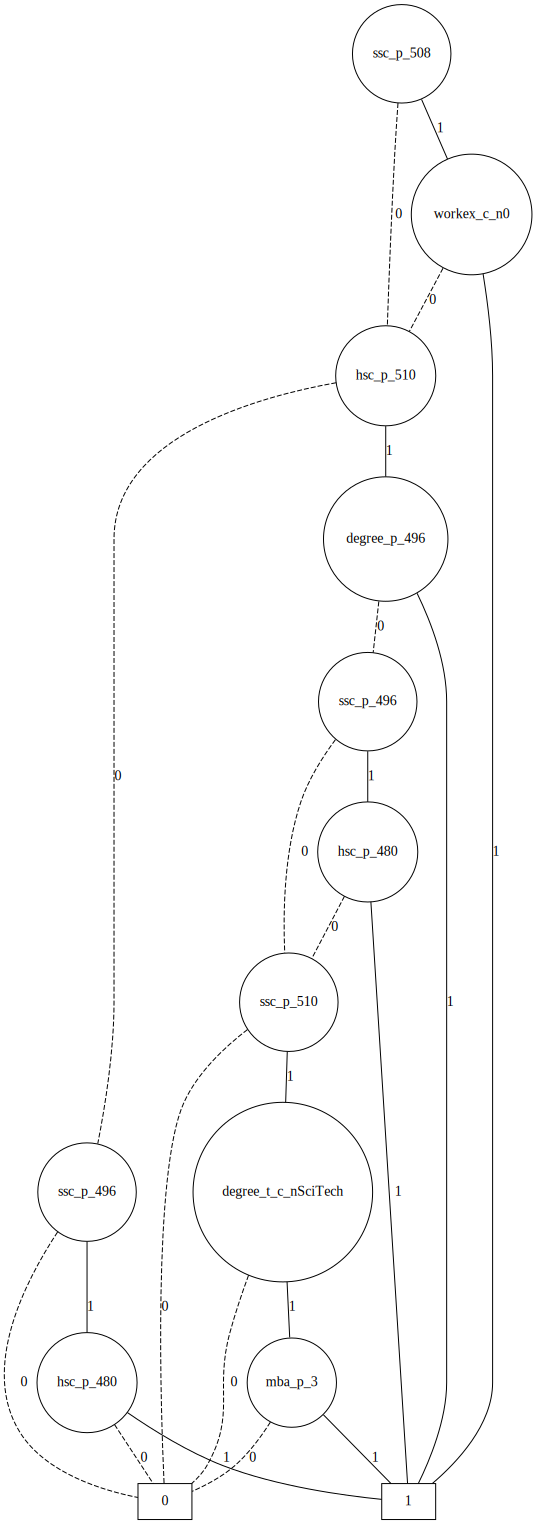

In [19]:
import gvmagic
%load_ext gvmagic

bdd1 = expr2bdd(c1.get_expr_w_constraints())
%dotobj bdd1

### Preprocessing the data

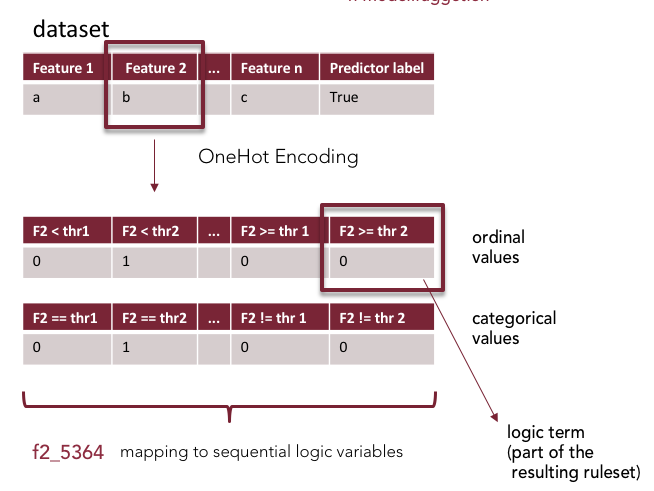

In [21]:
Image(filename='project-img/preprocessing.png') 

## Implementing the Nested Cavities algorithm with a Global Solver

Here I present my additions to the original codebase and the major parts of the algorithm, however the whole code will be imported, as it contains many unrelated but neccesary snippets as well.

The algorithm uses the CBS Integer Program solver by Coin-Or.

Modified AIX code snippet:

In [23]:
    def fit(self, X, y):
        if not self.silent:
            print('Learning {} rule with complexity parameters lambda0={}, lambda1={}'\
                  .format('CNF' if self.CNF else 'DNF', self.lambda0, self.lambda1))
        if self.CNF:
            # Flip labels for CNF
            y = 1 - y
        # Positive (y = 1) and negative (y = 0) samples
        P = np.where(y > 0.5)[0]
        Z = np.where(y < 0.5)[0]
        nP = len(P)
        n = len(y)

        # Initialize with all possible conjunctions
        # Feature indicator and conjunction matrices
        z = pd.DataFrame(np.array(list(product([0, 1], repeat=X.shape[1]))).T, index=X.columns)
        A = 1 - (np.dot(1 - X, z) > 0)

        # Iteration counter
        self.it = 0

        # Formulate master LP
        # Variables
        w = cvx.Variable(A.shape[1], integer=True)
        xi = cvx.Variable(nP, integer=True)
        
        # Cost function, to bound to model's complexity
        cs = self.lambda0 + self.lambda1 * z.sum().values
        cs[0] = 0
        # Objective function 
        # Here are the weighted sums, to identify the confusion metrics
        obj = cvx.Minimize(cvx.sum(xi * self.omegaFN) / n + cvx.sum(A[Z,:] * w * self.omegaFP) / n + cs * w)
        # Constraints
        constraints = [xi + A[P,:] * w >= 1, xi >= 0, xi <= 1, w >= 0, w <= 1]

        # Solve problem
        prob = cvx.Problem(obj, constraints)
        prob.solve(solver=self.solver, verbose=self.verbose)
        if not self.silent:
            print('Initial LP solved')

        # Extract variables
        sum1 = np.sum(xi.value * self.omegaFN) / n
        sum2 = np.sum(A[Z, :] * w.value * self.omegaFP) / n
        sum3 = np.sum(cs * w.value)

        # Save generated conjunctions and LP solution
        self.z = z
        self.wLP = w.value
        print(prob.value)
        print(self.wLP)
        
        self.w = self.wLP

        print(f"self.w \n {self.w} \n")
        if len(self.w) == 0:
            self.w = np.zeros_like(self.wLP, dtype=int)

        return sum1, sum2, sum3

Nested cavities algorithm:

In [25]:
class NestedCavities:
    def __init__(self, dataset, cat_list, drop_list, target_n, target_v, FPcost, FNcost, complexity, complexity_rate,
                 max_iter):
        self.df = dataset
        self.categories = cat_list
        self.to_drop = drop_list
        self.target_n = target_n
        self.target_v = target_v
        self.c_fp = FPcost
        self.c_fn = FNcost
        self.c = complexity
        self.c_rate = complexity_rate
        self.max_iter = max_iter

    def process(self, data, cat_list, drop_list, target_n, target_v, pos):
        """
        FeatureBinarizer throws an exception if the dataset which it needs to binarize consist of only 2 or less rows.
        The workaround is to inject a dummy sample to the dataset, then remove it after binarization.
        """
        trunkAtEnd = 0
        if len(data) < 3:
            dummy_dims = 3 - len(data)
            trunkAtEnd = dummy_dims
            df_padded = pd.DataFrame(columns=data.columns)
            for i in range(dummy_dims):
                df_padded.loc[i] = np.zeros(len(data.columns))
            data = pd.concat([df_padded, data])

        self.fb = FeatureBinarizer(colCateg=cat_list, numThresh=2, negations=True, returnOrd=True)
        X = data.drop(columns=drop_list)
        X_bin, X_std = self.fb.fit_transform(X)

        if pos:
            Y = data[target_n].map(lambda x: 1 if x == target_v else 0).astype(int)
        else:
            Y = data[target_n].map(lambda x: 1 if x != target_v else 0).astype(int)

        if trunkAtEnd > 0:
            return X_bin[trunkAtEnd:], Y[trunkAtEnd:]

        return X_bin, Y

    def fit_cavity(self, bin_v, target_v, complexity, FPcost, FNcost):

        br_model = BooleanRuleCG(complexity, complexity, omegaFP=FPcost, omegaFN=FNcost, CNF=False)
        # Train, print, and evaluate model
        sum1, sum2, sum3 = br_model.fit(bin_v, target_v)
        with open("sum_logger.txt", "a+") as sum_logger:
            sum_logger.write("New iteration \n")
            sum_logger.write(str(sum1) + ', ' + str(sum2) + ', ' + str(sum3) + '\n')

        return br_model

    def filter_data(self, dataset, bin_v, rules, pos):

        target = 1 if pos else 0
        filtered_df = pd.DataFrame(columns=dataset.columns)

        for i, sample in bin_v.iterrows():
            if rules.predict(sample) == target:
                filtered_df.loc[i] = dataset.loc[i]

        return filtered_df

    def subtract_rules(self, ruleset, neg_rules):
        sub_rules = TransformLogical(neg_rules, self.fb.thresh)
        if ruleset is None:
            return sub_rules.get_expr()
        else:
            return Xor(ruleset, sub_rules.get_expr(), simplify=False)

    def good_enough(self, prev_set, current_set, n_iter, end):
        if n_iter == self.max_iter or current_set.equals(prev_set) or end:
            return True
        else:
            return False

    def evaluate(self, filtered_data, stats_holder, dnf_rules):
        # processing the Y values [dataset - predicted]
        Y_pred = []
        for i, row in self.df.iterrows():
            if i in filtered_data.index:
                Y_pred.append(1)
            else:
                Y_pred.append(0)

        Y_org = self.df[self.target_n].map(lambda x: 1 if x == self.target_v else 0).astype(int)

        # evaluating confusion values
        conf_matrix = confusion_matrix(Y_org, Y_pred)
        conf = []
        for i, count in enumerate(conf_matrix.flatten()):
            conf.append(count)
        stats_holder["confusion"].append(conf)

        # evaluating accuracy
        stats_holder["accuracy"].append(accuracy_score(Y_org, Y_pred))

        # evaluating complexity
        c = 0
        for phase in dnf_rules:
            for conj in phase:
                c += 1
                terms = conj.split(" AND ")
                for term in terms:
                    c += 1
        stats_holder["complexity"].append(c)

        return stats_holder

    def learn(self):
        dnf_ruleset = []
        tr_ruleset = None
        model_stats = dict()
        model_stats["accuracy"] = []
        model_stats["complexity"] = []
        model_stats["confusion"] = []
        prev_samples = pd.DataFrame()
        pos_class_samples = pd.DataFrame(columns=self.df.columns)
        dataset = self.df
        n_iter = 1
        end = False
        while not self.good_enough(prev_samples, pos_class_samples, n_iter, end):
            # getting all the positives + some false positives
            tr_X, tr_Y = self.process(dataset, self.categories, self.to_drop, self.target_n, self.target_v, True)

            print(f"Phase {n_iter} / I.")

            rules = self.fit_cavity(tr_X, tr_Y, complexity=self.c, FNcost=self.c_fn, FPcost=self.c_fp)
            filtered_data = self.filter_data(dataset, tr_X, rules, True)
            removed_data1 = self.filter_data(dataset, tr_X, rules, False)

            dnf_ruleset.append(rules.explain()['rules'])
            tr_ruleset = self.subtract_rules(tr_ruleset, rules.explain()['rules'])
            self.evaluate(pd.concat([pos_class_samples, filtered_data]), model_stats, dnf_ruleset)

            if filtered_data.groupby(by=self.target_n).size()[self.target_v] == len(filtered_data):
                print("Filtered out all the negative values")
                end = True

            self.c *= 0.8
            if not end:
                # removing all the negatives + some false negatives
                tr_X, tr_Y = self.process(filtered_data, self.categories, self.to_drop, self.target_n,
                                          self.target_v, False)

                print(f"Phase {n_iter} / II.")

                rules = self.fit_cavity(tr_X, tr_Y, complexity=self.c, FNcost=self.c_fn, FPcost=self.c_fp)
                filtered_data2 = self.filter_data(filtered_data, tr_X, rules, False)
                removed_data2 = self.filter_data(filtered_data, tr_X, rules, True)

                dnf_ruleset.append(rules.explain()['rules'])
                tr_ruleset = self.subtract_rules(tr_ruleset, rules.explain()['rules'])

                # end of the iteration
                prev_samples = pos_class_samples
                pos_class_samples = pd.concat([pos_class_samples, filtered_data2])
                self.c *= 0.5
                dataset = removed_data2
                self.evaluate(pos_class_samples, model_stats, dnf_ruleset)
                n_iter += 1

                if self.target_v not in removed_data2[self.target_n].unique():
                    print("Filtered out all the negative values, finishing.")
                    end = True

            else:
                pos_class_samples = pd.concat([pos_class_samples, filtered_data])

        return pos_class_samples, dnf_ruleset, tr_ruleset, model_stats



For demonstration I used the Iris dataset (https://archive.ics.uci.edu/ml/datasets/iris), from which I have removed a class to shrink the problem into a binary classification. Also FeatureBinarizer was set to divide the set of interpretability to 3 parts in order to keep the dimensions narrow, and the global solver manageable.

In [2]:
data = pd.read_csv("../datasets/Iris.csv")

data = data.drop(data[data["Species"] == "Iris-setosa"].index)

In [3]:
from boolean_rule_cg_global import *
from nestedCavities_iris import *

In [ ]:
cat_list = []
drop_list = ["Id", "Species"]
target_n = "Species"
target_v = "Iris-versicolor"
FPcost = 0.5
FNcost = 2
complexity = 0.01
complexity_rate = 0.1
max_iter = 10
with open("sum_logger.txt", "w") as sum_logger:
    sum_logger.write("NESTED CAVITIES RESULTS: \n")
nc = NestedCavities(data, cat_list, drop_list, target_n, target_v, FPcost, FNcost, complexity, complexity_rate,
                    max_iter)

p_samples, dnf, logic, stats = nc.learn()
print(stats)
print(dnf)
print(logic)
print(f"Accuracy: {p_samples.groupby(by=target_n).size()[target_v] / data.groupby(by=target_n).size()[target_v]}")

with open("sum_logger.txt", "a+") as sum_logger:
    sum_logger.write("\n\nAIX360 results: \n")
aix_stats = compare_aix(data, cat_list, drop_list, target_n, target_v)

# plotting the confusion values
import plotly.graph_objects as go

nPos = data[data[target_n] == target_v].count()[0]
nNeg = data[data[target_n] != target_v].count()[0]
conf_stats = np.array(stats["confusion"]) / np.array([nPos, nNeg, nPos, nNeg])
fig_conf = go.Figure()
param_name = ["TPR", "FPR", "FNR", "TNR"]

for i, _ in enumerate(conf_stats):
    fig_conf.add_trace(go.Scatter(y=conf_stats[:, i],
                                  mode='lines+markers',
                                  name=param_name[i]))
fig_conf.write_image("confusion.png")

fig_acc_compl = go.Figure()
acc_stats = np.array(stats["accuracy"])
comp_stats = np.array(stats["complexity"])
fig_acc_compl.add_trace(go.Scatter(x=comp_stats, y=acc_stats,
                                   mode='lines+markers',
                                   name="Nested Cavities"))
fig_acc_compl.add_trace(go.Scatter(x=aix_stats["complexity"], y=aix_stats["accuracy"],
                                   mode='lines+markers',
                                   name="AIX360"))
fig_acc_compl.write_image("comp_acc.png")


### Comparing the two methods

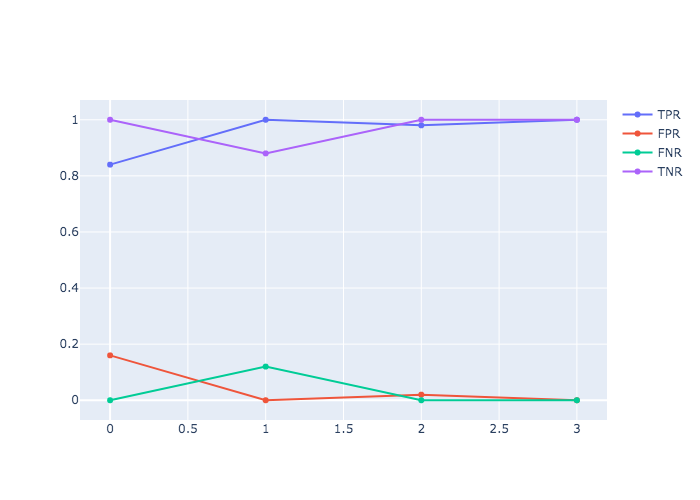

In [5]:
Image(filename='confusion.png') 

In this diagram the inner mechanics of the algorithm - alternating confusion parameters - are showcased. It is also clearly visible that after the 3rd phase (2nd iteration / 1st phase) all samples in each class are separated, and the TPR converges to 100% meantime the TNR declines to 0.

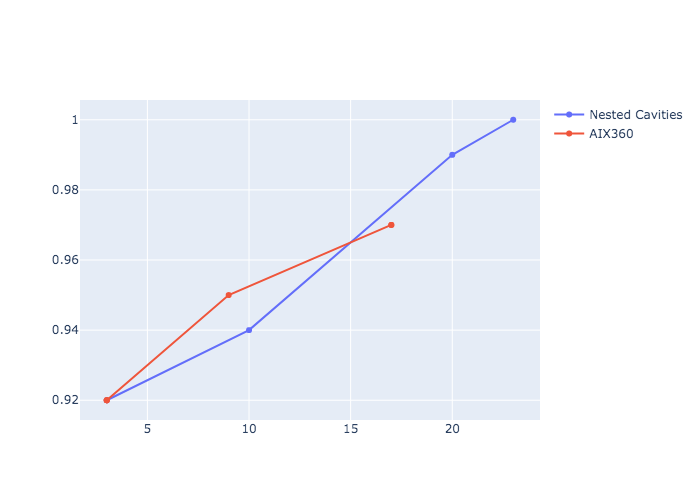

In [6]:
Image(filename='comp_acc.png') 

In this diagram the main characteristics of the two algorithms are presented. Meanwhile the AIX algorithm provides better performance with simpler rules, it struggles give a better performing model even with almost unlimited complexity. (It cannot provide a better one than it did with C = 17). However the algorithm proposed in this notebook was able to find the perfect solution (global optimum).